### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
%matplotlib inline
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

import time
from sklearn import metrics

### Getting Data
##### Getting Data From Csv's

In [2]:
cards_data = pd.read_csv('datasets/cards_data.csv')
users_data = pd.read_csv('datasets/users_data.csv')
users_data.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


##### Getting Data From Json's

In [3]:
with open('datasets/mcc_codes.json','r') as mcc_codes:
    data = json.load(mcc_codes)
with open('datasets/train_fraud_labels.json','r') as fraud_label:
    target = json.load(fraud_label)

In [4]:
mcc_codes = pd.DataFrame(list(data.items()), columns=['mcc', 'Description'])
fraud_label_target = pd.DataFrame(list(target.get('target').items()), columns=['transaction_id', 'fraud'])

##### Getting Data from Database

In [5]:
from db_connection import connect_to_db
connection = connect_to_db()
query = "SELECT * FROM transaction"
transaction_data = pd.read_sql(query, connection)

In [6]:
fraud_label_target.transaction_id  = fraud_label_target.transaction_id.astype(int)
transaction_data.date = pd.to_datetime(transaction_data.date)

### Merging and preprocessing the required DataFrames

In [7]:
transaction_data.head()

,id,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None


In [8]:
online_mask = transaction_data['merchant_city'] == 'ONLINE'
transaction_data.loc[online_mask, 'merchant_state'] = 'ONLINE'
transaction_data.loc[online_mask, 'zip'] = 'ONLINE'
transaction_data['zip'] = transaction_data['zip'].fillna('FOREIGN') 

In [9]:
import pgeocode

nomi = pgeocode.Nominatim('us')

valid_zip_mask = ~transaction_data['zip'].isin(['ONLINE', 'FOREIGN'])
numeric_zip_mask = transaction_data['zip'].apply(lambda x: str(x).isdigit() if pd.notna(x) else False)
valid_zips = transaction_data.loc[valid_zip_mask & numeric_zip_mask, 'zip'].astype(str)

unique_zips = valid_zips.unique()

lat_lon_lookup = pd.DataFrame(unique_zips, columns=['zip'])
lat_lon_lookup[['t_latitude', 't_longitude']] = lat_lon_lookup['zip'].apply(
    lambda z: pd.Series(nomi.query_postal_code(z)[['latitude', 'longitude']])
)

transaction_data = transaction_data.merge(lat_lon_lookup, on='zip', how='left')

In [10]:
transaction_data['transaction_type'] = transaction_data.apply(
    lambda row: 'ONLINE' if row['zip'] == 'ONLINE' 
    else ('FOREIGN' if row['zip'] == 'FOREIGN' else 'OFFLINE'),
    axis=1
)

In [11]:
transaction_data['repeat_transaction'] = transaction_data.duplicated(
    subset=['client_id', 'merchant_id','transaction_type'], keep='first'
)
transaction_data['repeat_transaction'] = transaction_data['repeat_transaction'].astype(int)

In [12]:
transaction_fraud = transaction_data.merge(fraud_label_target,how='left',left_on='id', right_on='transaction_id')
transaction_fraud.drop(['id','transaction_id'],inplace=True,axis =1)

In [13]:
main_df = transaction_fraud.merge(users_data[['id','latitude', 'longitude']],how='left',left_on='client_id', right_on='id')
main_df.drop('id',inplace=True,axis =1)

In [14]:
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,t_latitude,t_longitude,transaction_type,repeat_transaction,fraud,latitude,longitude
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,47.2707,-101.8075,OFFLINE,0,No,46.80,-100.76
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,41.5509,-90.4942,OFFLINE,0,No,40.80,-91.12
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,33.2131,-117.2243,OFFLINE,0,No,33.18,-117.29
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,41.4236,-87.3556,OFFLINE,0,NaN,41.42,-87.35
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,38.8582,-76.6145,OFFLINE,0,No,38.86,-76.60


In [15]:
mask = (
    (main_df['transaction_type'] == 'OFFLINE') &
    main_df[['latitude','longitude','t_latitude','t_longitude']].notna().all(axis=1)
)

# Vectorized haversine
lat1 = np.radians(main_df.loc[mask, 'latitude'])
lon1 = np.radians(main_df.loc[mask, 'longitude'])
lat2 = np.radians(main_df.loc[mask, 't_latitude'])
lon2 = np.radians(main_df.loc[mask, 't_longitude'])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

main_df.loc[mask, 'distance_km'] = 6371.0 * c  # Earth radius in km

# Optional: distance in miles
main_df['distance_miles'] = main_df['distance_km'] * 0.621371

In [16]:
del lat_lon_lookup
del valid_zips
del unique_zips
del users_data
del cards_data
del mcc_codes
del transaction_data
del transaction_fraud
del mask


import gc
gc.collect()

0

In [17]:
main_df['updated_amt'] = np.where(main_df.amount<0,main_df.amount*-1,main_df.amount)
main_df['fraud'] = main_df['fraud'].map({'Yes': 1, 'No': 0})
main_df.fraud.isna().sum()

np.int64(4390952)

In [18]:
# Creating a new dataframe by grouping in order to calculate risk score for each client
client_card_df = main_df[['client_id','card_id','fraud','updated_amt']].groupby(['client_id','card_id','fraud']).agg(
        mean_amount=('updated_amt', 'mean'),
        max_amount=('updated_amt', 'max'),
        min_amount=('updated_amt', 'min'),
        total_amount=('updated_amt', 'sum'),
        count=('updated_amt', 'count')
    ).reset_index()
client_card_df.head()

,client_id,card_id,fraud,mean_amount,max_amount,min_amount,total_amount,count
0,0,1271,0.0,45.904068,577.46,0.65,212122.70,4621
1,0,1271,1.0,30.260000,45.48,15.04,60.52,2
2,0,4639,0.0,80.186643,1128.47,0.78,322270.12,4019
3,0,4639,1.0,70.697500,129.40,5.13,282.79,4
4,1,3682,0.0,39.487578,542.66,0.54,45331.74,1148


In [19]:
# Aggregate fraud and total data    
grouped = client_card_df.groupby(['client_id', 'card_id', 'fraud']).agg(
    fraud_count=('count', 'sum'),
    fraud_amount=('total_amount', 'sum')
).reset_index()

# Pivot to get fraud and non-fraud side by side
pivoted = grouped.pivot(index=['client_id', 'card_id'], columns='fraud', values=['fraud_count', 'fraud_amount'])
pivoted.columns = ['count_nonfraud', 'count_fraud', 'amount_nonfraud', 'amount_fraud']
pivoted = pivoted.fillna(0).reset_index()

# Calculate percentages
pivoted['fraud_count_pct'] = round(100 * pivoted['count_fraud'] / (pivoted['count_fraud'] + pivoted['count_nonfraud']),2)
pivoted['fraud_amount_pct'] = round(100 * pivoted['amount_fraud'] / (pivoted['amount_fraud'] + pivoted['amount_nonfraud']),2)


In [20]:
pivoted.sort_values('fraud_count_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
1886,944,372,215.0,7.0,16559.83,302.10,3.15,1.79
1016,496,5806,744.0,25.0,55509.13,1953.57,3.25,3.40
3540,1746,3754,378.0,13.0,9137.06,5125.89,3.32,35.94
954,467,4481,140.0,5.0,4808.77,399.07,3.45,7.66
1553,764,1381,301.0,11.0,15931.26,518.41,3.53,3.15
1204,604,4280,281.0,11.0,5293.04,4386.14,3.77,45.32
1952,980,181,234.0,10.0,10426.70,982.01,4.10,8.61
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1524,754,2219,199.0,9.0,6271.47,680.40,4.33,9.79
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45


In [21]:
pivoted.sort_values('fraud_amount_pct').tail(20)

,client_id,card_id,count_nonfraud,count_fraud,amount_nonfraud,amount_fraud,fraud_count_pct,fraud_amount_pct
3428,1694,5032,1252.0,19.0,22950.16,2953.21,1.49,11.40
2335,1176,2629,210.0,9.0,15160.67,1957.95,4.11,11.44
1687,840,4992,264.0,5.0,8744.63,1199.46,1.86,12.06
3716,1833,2345,341.0,6.0,18923.75,2815.74,1.73,12.95
3939,1942,246,1607.0,5.0,8350.50,1254.38,0.31,13.06
2622,1302,3972,62.0,3.0,528.90,82.17,4.62,13.45
2024,1016,5883,501.0,8.0,9896.90,1992.37,1.57,16.76
3918,1928,2442,894.0,19.0,11905.08,2828.68,2.08,19.20
2981,1492,2171,560.0,9.0,4755.17,1461.11,1.58,23.50
2188,1102,3952,1413.0,37.0,20193.51,7097.85,2.55,26.01


In [22]:
# Function to calculate risk score
def compute_risk_score(row):
    fraud_amt_threshold = pivoted[pivoted['fraud_count_pct']>0]['amount_fraud'].quantile(0.75)
    fraud_cnt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_count_pct'].quantile(0.75)
    fraud_amt_pct_threshold = pivoted[pivoted['fraud_count_pct']>0]['fraud_amount_pct'].quantile(0.75)
    score = 0
    if row['fraud_count_pct'] > fraud_cnt_pct_threshold:
        score += 1
    if row['fraud_amount_pct'] > fraud_amt_pct_threshold:
        score += 1
    if row['amount_fraud'] > fraud_amt_threshold:
        score += 1
    return score

In [23]:
pivoted['risk_score'] = pivoted.apply(compute_risk_score, axis=1)

In [24]:
main_df = main_df.merge(pivoted.rename(columns={'card_id': 'cc_id'})[['risk_score', 'cc_id']],how='left',left_on='card_id',right_on='cc_id')
main_df.drop('cc_id',inplace=True,axis =1)
main_df.head()

,date,client_id,card_id,amount,transaction_mode,merchant_id,merchant_city,merchant_state,zip,mcc,error,t_latitude,t_longitude,transaction_type,repeat_transaction,fraud,latitude,longitude,distance_km,distance_miles,updated_amt,risk_score
0,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,None,47.2707,-101.8075,OFFLINE,0,0.0,46.80,-100.76,95.084379,59.082675,77.00,3.0
1,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,None,41.5509,-90.4942,OFFLINE,0,0.0,40.80,-91.12,98.563877,61.244735,14.57,0.0
2,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,None,33.2131,-117.2243,OFFLINE,0,0.0,33.18,-117.29,7.135686,4.433909,80.00,0.0
3,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,None,41.4236,-87.3556,OFFLINE,0,NaN,41.42,-87.35,0.615033,0.382164,200.00,0.0
4,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,None,38.8582,-76.6145,OFFLINE,0,0.0,38.86,-76.60,1.271358,0.789985,46.41,2.0


In [25]:
del pivoted
del grouped
del client_card_df
gc.collect()

0

In [26]:
columns = ['amount','transaction_type', 'repeat_transaction', 'transaction_mode','distance_km','risk_score','fraud']
main_df = main_df[columns]
main_df.head()

,amount,transaction_type,repeat_transaction,transaction_mode,distance_km,risk_score,fraud
0,-77.00,OFFLINE,0,Swipe Transaction,95.084379,3.0,0.0
1,14.57,OFFLINE,0,Swipe Transaction,98.563877,0.0,0.0
2,80.00,OFFLINE,0,Swipe Transaction,7.135686,0.0,0.0
3,200.00,OFFLINE,0,Swipe Transaction,0.615033,0.0,NaN
4,46.41,OFFLINE,0,Swipe Transaction,1.271358,2.0,0.0


In [27]:
main_df[['transaction_type', 'repeat_transaction', 'transaction_mode','risk_score']].nunique()

transaction_type      3
repeat_transaction    2
transaction_mode      3
risk_score            4
dtype: int64

In [28]:
# Separating the data who have 'null' in fraud
final_test_df = main_df[main_df.fraud.isna()].drop('fraud',axis =1)
print(final_test_df.shape)
final_test_df.head()

(4390952, 6)


,amount,transaction_type,repeat_transaction,transaction_mode,distance_km,risk_score
3,200.00,OFFLINE,0,Swipe Transaction,0.615033,0.0
6,77.00,OFFLINE,1,Swipe Transaction,95.084379,3.0
8,261.58,ONLINE,0,Online Transaction,NaN,0.0
9,10.74,OFFLINE,0,Swipe Transaction,2.339468,0.0
15,1.09,OFFLINE,0,Swipe Transaction,46.724910,0.0


In [29]:
main_df.dropna(subset = ['fraud'], inplace=True)

##### Image for Correlation plot - https://github.com/yashjadwani/Financial-Fraud-Analysis/blob/main/Corr%20plot.png
##### Code for detailed Analysis and EDA - https://github.com/yashjadwani/Financial-Fraud-Analysis/blob/main/fraud_detection.ipynb

## Model Building
##### Splitting and Scaling the Data

In [30]:
X = main_df.drop(columns=['fraud'])
y = main_df['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
cat_cols = ['transaction_type', 'repeat_transaction', 'transaction_mode','risk_score']
num_cols = ['distance_km']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
        ('num', MinMaxScaler(), num_cols)
    ]
)

In [38]:
X_train

,amount,transaction_type,repeat_transaction,transaction_mode,distance_km,risk_score
10972778,42.22,OFFLINE,1,Chip Transaction,0.755237,0.0
10224558,24.61,OFFLINE,1,Chip Transaction,0.405677,0.0
245344,3.63,OFFLINE,1,Swipe Transaction,4.201175,0.0
9360313,2.47,OFFLINE,1,Chip Transaction,NaN,0.0
4426608,15.08,OFFLINE,1,Swipe Transaction,19.663224,0.0
...,...,...,...,...,...,...
10752903,148.80,OFFLINE,1,Chip Transaction,4.359933,2.0
3336705,111.97,OFFLINE,1,Swipe Transaction,12.734584,0.0
6425641,2.50,OFFLINE,1,Swipe Transaction,11.035469,0.0
9777456,17.52,OFFLINE,1,Swipe Transaction,NaN,0.0


In [39]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),

    "XGB Classifier": XGBClassifier(
        scale_pos_weight=99.6 / 0.4,
        random_state=42,
        eval_metric='logloss'
    ),

    "Decision Tree": DecisionTreeClassifier(
        criterion='entropy',
        max_depth=7,
        min_samples_leaf=2
    ),

    "Voting Hard": VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")),
            ('xgb', XGBClassifier(scale_pos_weight=99.6 / 0.4, random_state=42, eval_metric='logloss')),
            ('dt', DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2))
        ],
        voting='hard'
    ),

    "Voting Soft": VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")),
            ('xgb', XGBClassifier(scale_pos_weight=99.6 / 0.4, random_state=42, eval_metric='logloss')),
            ('dt', DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=2))
        ],
        voting='soft'
    )
}


In [40]:
pipelines = {
    name: Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', model)
    ])
    for name, model in models.items()
}

In [41]:

results = []

for name, pipe in pipelines.items():
    start = time.time()
    print(f"Training {name}")
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    try:
        proba = pipe.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, proba)
    except:
        auc = None
    
    results.append([
        name,
        accuracy_score(y_test, preds),
        precision_score(y_test, preds),
        recall_score(y_test, preds),
        f1_score(y_test, preds),
        auc,
        matthews_corrcoef(y_test, preds),
        round(time.time() - start,2),
        (preds == y_test).sum()
    ])

metrics_df = pd.DataFrame(results, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
    'ROC-AUC Score', 'MCC', 'Time', 'Correct Predictions'
])

Training Random Forest
Training XGB Classifier
Training Decision Tree
Training Voting Hard
Training Voting Soft


In [42]:
metrics_df.sort_values('MCC')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score,MCC,Time,Correct Predictions
0,Random Forest,0.967813,0.038860,0.874858,0.074415,0.956534,0.180527,1842.71,1725603
1,XGB Classifier,0.967468,0.039981,0.912400,0.076605,0.986866,0.187251,51.21,1724989
3,Voting Hard,0.971331,0.042987,0.864619,0.081902,NaN,0.189128,2497.94,1731877
4,Voting Soft,0.984479,0.073492,0.817975,0.134867,0.985445,0.242431,2013.21,1755320
2,Decision Tree,0.998565,0.557864,0.142586,0.227122,0.987114,0.281549,44.37,1780434


In [44]:
metrics_df.sort_values('Correct Predictions')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score,MCC,Time,Correct Predictions
1,XGB Classifier,0.967468,0.039981,0.912400,0.076605,0.986866,0.187251,51.21,1724989
0,Random Forest,0.967813,0.038860,0.874858,0.074415,0.956534,0.180527,1842.71,1725603
3,Voting Hard,0.971331,0.042987,0.864619,0.081902,NaN,0.189128,2497.94,1731877
4,Voting Soft,0.984479,0.073492,0.817975,0.134867,0.985445,0.242431,2013.21,1755320
2,Decision Tree,0.998565,0.557864,0.142586,0.227122,0.987114,0.281549,44.37,1780434


In [45]:
metrics_df.sort_values('Recall')

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC Score,MCC,Time,Correct Predictions
2,Decision Tree,0.998565,0.557864,0.142586,0.227122,0.987114,0.281549,44.37,1780434
4,Voting Soft,0.984479,0.073492,0.817975,0.134867,0.985445,0.242431,2013.21,1755320
3,Voting Hard,0.971331,0.042987,0.864619,0.081902,NaN,0.189128,2497.94,1731877
0,Random Forest,0.967813,0.038860,0.874858,0.074415,0.956534,0.180527,1842.71,1725603
1,XGB Classifier,0.967468,0.039981,0.912400,0.076605,0.986866,0.187251,51.21,1724989


#### XGB Training

In [32]:
XGB_Classifier =  XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    )


pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', XGB_Classifier)
    ])

In [33]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['transaction_type',
                                                   'repeat_transaction',
                                                   'transaction_mode',
                                                   'risk_score']),
                                                 ('num', MinMaxScaler(),
                                                  ['distance_km'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [34]:
from sklearn.metrics import precision_recall_curve
y_probs = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

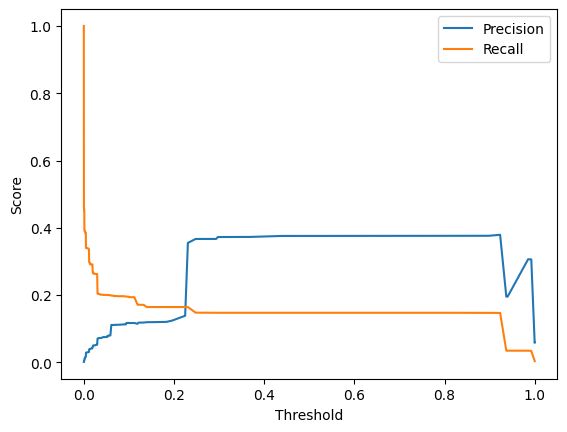

In [35]:
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [36]:
f1_scores = 2 * (precision * recall) / (precision + recall)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)

y_pred = (y_probs >= best_threshold).astype(int)

Best threshold: 0.23078309


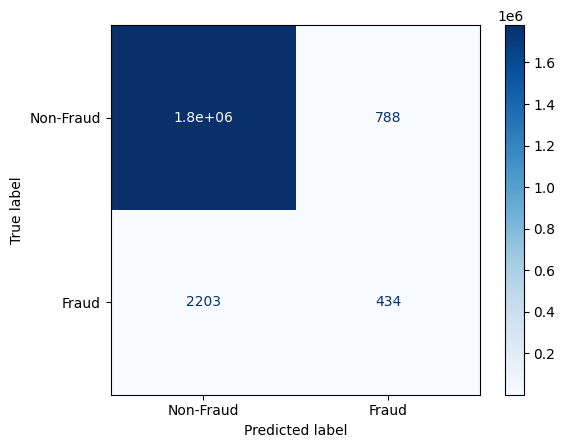

In [37]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=['Non-Fraud', 'Fraud']
)
cm_display.plot(cmap='Blues')
plt.show()

In [38]:
import joblib
import json
import os
save_dir = "Models/Classifier"

final_test_df.to_csv(os.path.join(save_dir, "final_test.csv"), index=False)

In [39]:

joblib.dump(pipeline, os.path.join(save_dir, "xgb_pipeline.pkl"))

['Models/Classifier\\xgb_pipeline.pkl']

##### Testing on Final DataSet

In [98]:
final_test_df.head()

,amount,transaction_type,repeat_transaction,transaction_mode,distance_km,risk_score,predicted_fraud
3,200.00,OFFLINE,0,Swipe Transaction,0.615033,0.0,0
6,77.00,OFFLINE,1,Swipe Transaction,95.084379,3.0,0
8,261.58,ONLINE,0,Online Transaction,NaN,0.0,0
9,10.74,OFFLINE,0,Swipe Transaction,2.339468,0.0,0
15,1.09,OFFLINE,0,Swipe Transaction,46.724910,0.0,0


In [99]:
y_probs_test = pipeline.predict_proba(final_test_df)[:, 1]
y_pred_test = (y_probs_test >= best_threshold).astype(int)

In [100]:
final_test_df['predicted_fraud'] = y_pred_test
final_test_df[final_test_df.predicted_fraud==1]

,amount,transaction_type,repeat_transaction,transaction_mode,distance_km,risk_score,predicted_fraud
341,26.13,OFFLINE,0,Swipe Transaction,10.440298,0.0,1
736,10.30,OFFLINE,0,Swipe Transaction,10.352352,0.0,1
830,1.01,OFFLINE,0,Swipe Transaction,11.035469,1.0,1
869,4.86,OFFLINE,0,Swipe Transaction,11.167735,0.0,1
1978,306.25,OFFLINE,0,Swipe Transaction,10.825428,0.0,1
...,...,...,...,...,...,...,...
13278607,84.96,FOREIGN,0,Chip Transaction,NaN,3.0,1
13282346,8.87,FOREIGN,0,Chip Transaction,NaN,3.0,1
13285137,4.03,FOREIGN,0,Chip Transaction,NaN,3.0,1
13296404,13.94,OFFLINE,1,Chip Transaction,4.086550,2.0,1
